# Unsupervised learning - Clustering

The goal of clustering:
> ... clustering is the task of partitioning the dataset into groups, called clusters. The goal is to split up the data in such a way that points within a single cluster are very similar and points in different clusters are different. Similarly to classification algorithms, clustering algorithms assign (or predict) a number to each data point, indicating which cluster a particular point belongs to.

A big part is interpreting the clusters. You need to know what the features represent, where your data comes from.

## KMeans Clustering

Follow:
- _Introduction to Machine Learning_ [Chapter 3](https://github.com/amueller/introduction_to_ml_with_python/blob/master/03-unsupervised-learning.ipynb) **Section 3.5.1 k-Means Clustering** 
- _Practical Statistics for Data Scientists_ [Chapter 7](https://github.com/gedeck/practical-statistics-for-data-scientists/blob/master/python/notebooks/Chapter%207%20-%20Unsupervised%20Learning.ipynb) K-Means algorithm


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import mglearn

## How does KMeans Clustering work?

**The number of clusters has to be chosen by the user first**

>The algorithm alternates between two steps: assigning each data point to the closest cluster center, and then setting each cluster center as the mean of the data points that are assigned to it

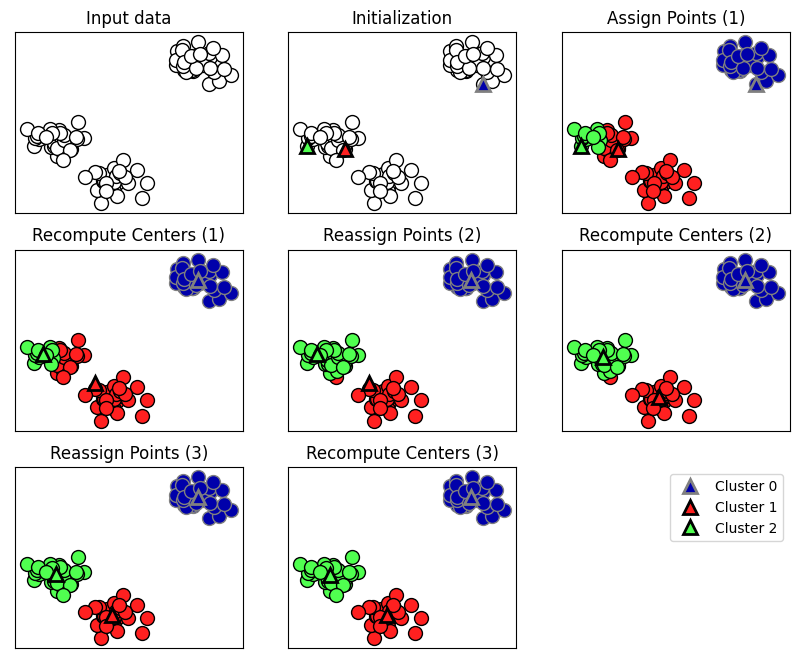

In [3]:
mglearn.plots.plot_kmeans_algorithm()

There is randomness involved -> set random_state for consistent results.

scikit-learn performs multiple clusterings `n_init=10` by default and returns the *best*.

### Scikit-learn code

In [4]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# generate synthetic two-dimensional data
X, y = make_blobs(random_state=1)

# build the clustering model
kmeans = KMeans(n_clusters=3, random_state=4, n_init=10)
kmeans.fit(X)

KMeans(n_clusters=3, n_init=10, random_state=4)

In [5]:
print("Cluster memberships:\n{}".format(kmeans.labels_))

Cluster memberships:
[0 1 1 1 2 2 2 1 0 0 1 1 2 0 2 2 2 0 1 1 2 1 2 0 1 2 2 0 0 2 0 0 2 0 1 2 1
 1 1 2 2 1 0 1 1 2 0 0 0 0 1 2 2 2 0 2 1 1 0 0 1 2 2 1 1 2 0 2 0 1 1 1 2 0
 0 1 2 2 0 1 0 1 1 2 0 0 0 0 1 0 2 0 0 1 1 2 2 0 2 0]


In [6]:
print("Cluster memberships:\n{}".format(kmeans.predict(X)))

Cluster memberships:
[0 1 1 1 2 2 2 1 0 0 1 1 2 0 2 2 2 0 1 1 2 1 2 0 1 2 2 0 0 2 0 0 2 0 1 2 1
 1 1 2 2 1 0 1 1 2 0 0 0 0 1 2 2 2 0 2 1 1 0 0 1 2 2 1 1 2 0 2 0 1 1 1 2 0
 0 1 2 2 0 1 0 1 1 2 0 0 0 0 1 0 2 0 0 1 1 2 2 0 2 0]


### Visualizing clusters and cluster centres

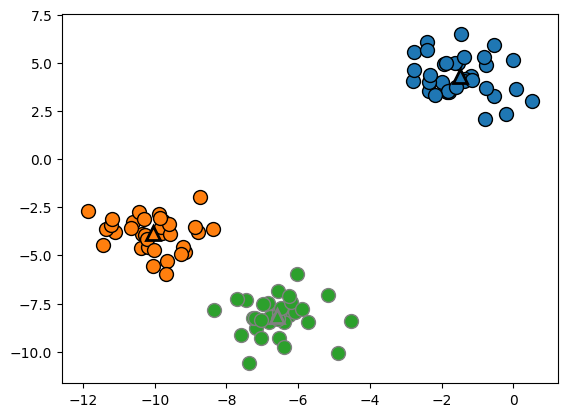

In [7]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers='o')
mglearn.discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2],
    markers='^', markeredgewidth=2);

## Another way to interpret Clustering

Code from Practical Statistics for Data Scientists [Unsupervised Learning](https://github.com/gedeck/practical-statistics-for-data-scientists/blob/master/python/notebooks/Chapter%207%20-%20Unsupervised%20Learning.ipynb)

### 1. Create a DataFrame with features and predicted labels

In [8]:
df = pd.DataFrame(X, columns=['f1', 'f2'])
df['label'] = kmeans.labels_
df['label'] = df['label'].astype('category') #seaborn plots will be nicer
df

,f1,f2,label
0,-0.794152,2.104951,0
1,-9.151552,-4.812864,1
2,-11.441826,-4.457814,1
3,-9.767618,-3.191337,1
4,-4.536556,-8.401863,2
...,...,...,...
95,-6.026058,-5.966248,2
96,-7.047473,-9.275247,2
97,-1.373973,5.291631,0
98,-6.253931,-7.108786,2


### 2. Create a DataFrame with cluster centres

In [9]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['f1', 'f2'])
centers

,f1,f2
0,-1.471082,4.337219
1,-10.049352,-3.859541
2,-6.581968,-8.172393


### 3. Plot features and cluster centres

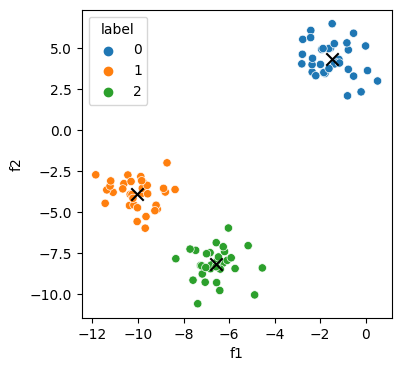

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.scatterplot(x='f1', y='f2', hue='label', ax=ax, data=df)

centers.plot.scatter(x='f1', y='f2', ax=ax, marker='x', s=80, color='black');

### 4. Check cluster balances
Small clusters might be noise

Counter({0: 34, 1: 33, 2: 33})


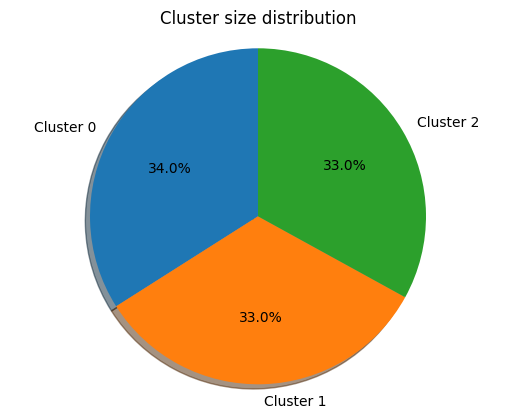

In [11]:
from collections import Counter
counts = Counter(kmeans.labels_)
print(counts)
fig1, ax1 = plt.subplots()
ax1.pie(counts.values(), labels=[f'Cluster {i}' for i in counts.keys()], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal');  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Cluster size distribution');

### 5. Plot means of the features in each cluster

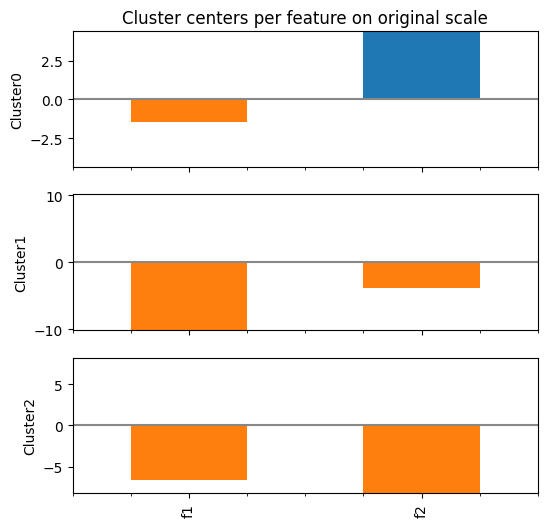

In [12]:
f, axes = plt.subplots(kmeans.n_clusters, 1, figsize=(6, 6), sharex=True)

for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l>0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster{i}')
    ax.set_ylim(-maxPC, maxPC)
    if i == 0:
        ax.set_title('Cluster centers per feature on original scale')

### 6. Interpret clusters

Now we could interpret and say:

- Cluster 2 contains samples with large negative values in both features
- Cluster 0 contains samples with large positive f2 values.
- Cluster 1 contains samples with large negative f1 values.

This would make more sense if we would know what the features f1 and f2 represent.

## Wine dataset

Because k-means clustering uses distances, we scale the features using a `StandardScaler()`.

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_wine

X, _ = load_wine(return_X_y=True, as_frame=True)
X_scaled = X.copy()

scaler = StandardScaler()
scaler.fit(X_scaled)
X_scaled = pd.DataFrame(scaler.transform(X_scaled), columns=X_scaled.columns)
X_scaled

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.876275,2.974543,0.305159,0.301803,-0.332922,-0.985614,-1.424900,1.274310,-0.930179,1.142811,-1.392758,-1.231206,-0.021952
174,0.493343,1.412609,0.414820,1.052516,0.158572,-0.793334,-1.284344,0.549108,-0.316950,0.969783,-1.129518,-1.485445,0.009893
175,0.332758,1.744744,-0.389355,0.151661,1.422412,-1.129824,-1.344582,0.549108,-0.422075,2.224236,-1.612125,-1.485445,0.280575
176,0.209232,0.227694,0.012732,0.151661,1.422412,-1.033684,-1.354622,1.354888,-0.229346,1.834923,-1.568252,-1.400699,0.296498


### K-means with 3 clusters (arbitrary choice)

In [14]:
kmeans = KMeans(n_clusters=3, random_state=54, n_init=10)
kmeans.fit(X_scaled)
# y_kmeans = kmeans.predict(df_scaled)
X['clusters'] = kmeans.labels_
X['clusters'] = X['clusters'].astype('category') #makes seaborn use qualitative color palette

### Cluster centers in orginal and scaled spaces

In [15]:
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
centers_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=X_scaled.columns)
centers

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,13.676774,1.997903,2.466290,17.462903,107.967742,2.847581,3.003226,0.292097,1.922097,5.453548,1.065484,3.163387,1100.225806
1,12.250923,1.897385,2.231231,20.063077,92.738462,2.247692,2.050000,0.357692,1.624154,2.973077,1.062708,2.803385,510.169231
2,13.134118,3.307255,2.417647,21.241176,98.666667,1.683922,0.818824,0.451961,1.145882,7.234706,0.691961,1.696667,619.058824


### Visualize clusters and centers

We have more than two dimensions:
1. We choose a single pair
2. We use PCA to reduce the dimensions

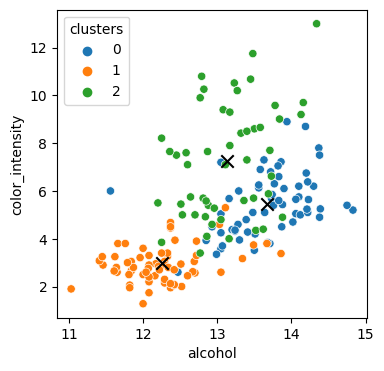

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.scatterplot(x='alcohol', y='color_intensity', hue='clusters', ax=ax, data=X)

centers.plot.scatter(x='alcohol', y='color_intensity', ax=ax, marker='x', s=80, color='black');

<AxesSubplot: >

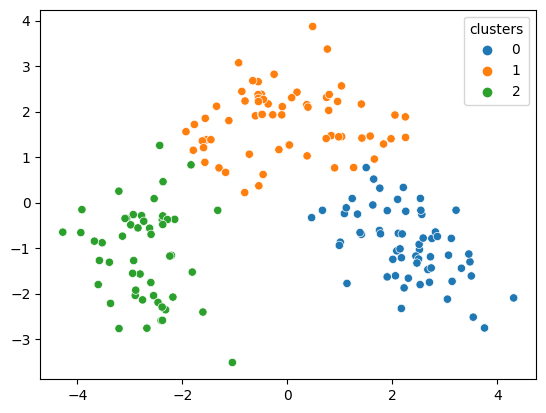

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_2D = pca.transform(X_scaled)
sns.scatterplot(x=X_2D[:,0], y=X_2D[:,1], hue=X['clusters'])

### Cluster proportions

Counter({1: 65, 0: 62, 2: 51})


Text(0.5, 1.0, 'Cluster size distribution')

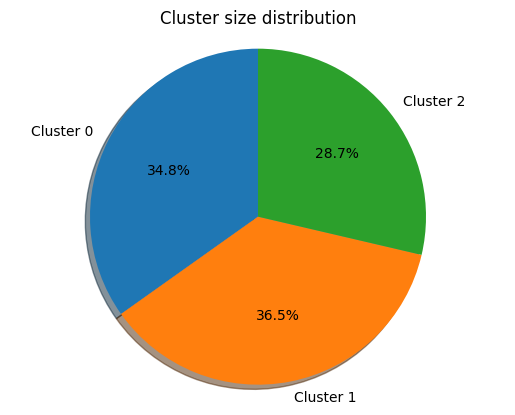

In [18]:
from collections import Counter
counts = Counter(kmeans.labels_)
print(counts)
fig1, ax1 = plt.subplots()
ax1.pie(counts.values(), labels=[f'Cluster {i}' for i in counts.keys()], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal');  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Cluster size distribution')

### Values of cluster centres in scaled space

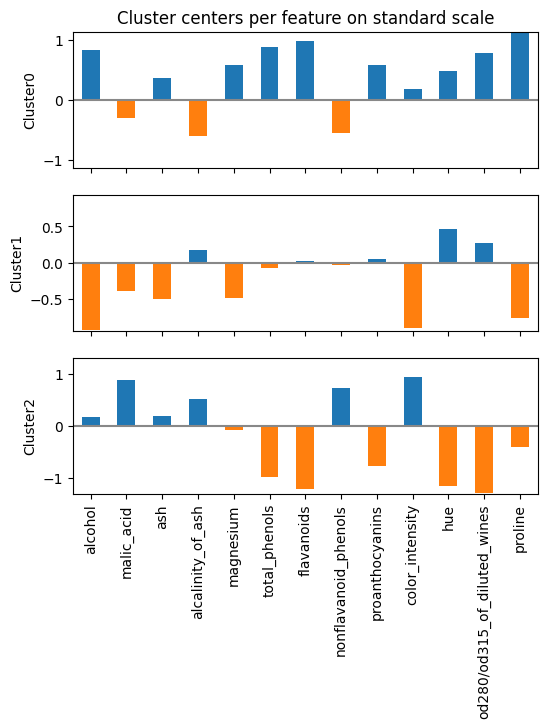

In [19]:
f, axes = plt.subplots(kmeans.n_clusters, 1, figsize=(6, 6), sharex=True)

for i, ax in enumerate(axes):
    center = centers_scaled.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l>0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster{i}')
    ax.set_ylim(-maxPC, maxPC)
    if i == 0:
        ax.set_title('Cluster centers per feature on standard scale')

### Interpretation

Because it is in scaled space, the above plots are with respect to the average value

Cluster 0: High alcohol, medium acidity and medium color intensity wines

Cluster 1: Medium alcohol, high acidity with high color intensity wines

Cluster 2: Low alcohol, low acidity with low color intensity wines

Another approach would be to group the features and comment on the feature groups. This requires domain knowledge